In [1]:
import sys  
sys.path.insert(0, '../')

from connection_to_db import connection

sys.path.insert(0, '/')

from preprocess import preprocess as preprocess_data

In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
departures_test_name = 'departures_to_test'
departures_train_name = 'departures'

weather_test_name = 'weather_predict'
weather_train_name = 'weather'

In [4]:
_, conn, cur = connection()

In [5]:
def get_data(connection, table_name, weather_table_name, is_train=False):
    query = f'''
        SELECT * 
        FROM {table_name}
        LEFT JOIN {weather_table_name} ON {weather_table_name}.datetime = {table_name}.datetime_round
    '''
    if is_train:
        query += ' WHERE delay IS NOT NULL'
    data = pd.read_sql(query, connection)
    return data

In [111]:
def additional_preprocess(data):
    data = data.drop(columns=['scheduled_datetime', 'date']).fillna(0)
    return data

In [112]:
test = get_data(conn, departures_test_name, weather_test_name)
test = preprocess_data(test)
test = additional_preprocess(test)
test = test.drop(columns=['delay'])
test.head()

,carrier_code,flight,destination_airport,temp,humidity,precip,preciptype,snowdepth,windgust,windspeed,...,cloudcover,visibility,solarradiation,conditions,winspeed_greater_17,is_freezing_rain,is_first_day_half,weekday,is_weekend,season
0,51,7454,8,38.0,88.6,0.4,4,0.2,33.3,20.8,...,100.0,1.6,0.0,0,1,0,False,3,False,3
1,51,7452,8,38.0,88.6,0.4,4,0.2,33.3,20.8,...,100.0,1.6,0.0,0,1,0,False,3,False,3
2,51,7458,8,38.0,88.6,0.4,4,0.2,33.3,20.8,...,100.0,1.6,0.0,0,1,0,False,3,False,3
3,51,7456,8,38.0,88.6,0.4,4,0.2,33.3,20.8,...,100.0,1.6,0.0,0,1,0,False,3,False,3
4,16,6444,110,38.0,88.6,0.4,4,0.2,33.3,20.8,...,100.0,1.6,0.0,0,1,0,False,3,False,3


In [113]:
train = get_data(conn, departures_train_name, weather_train_name)
train = preprocess_data(train, is_data_train=True)
train.head()

,carrier_code,flight,destination_airport,scheduled_datetime,date,delay,temp,humidity,precip,preciptype,...,cloudcover,visibility,solarradiation,conditions,winspeed_greater_17,is_freezing_rain,is_first_day_half,weekday,is_weekend,season
0,68,3001,193,20:35:00,2022-07-16,0.0,70.2,78.5,0.0,2,...,97.4,9.9,7.0,5,0,0,False,5,True,1
1,68,3010,193,08:42:00,2022-07-16,0.0,68.1,89.8,0.0,2,...,100.0,8.3,83.0,5,0,0,True,5,True,1
2,68,3015,118,08:18:00,2022-07-16,0.0,68.1,89.8,0.0,2,...,100.0,8.3,83.0,5,0,0,True,5,True,1
3,68,3032,101,10:30:00,2022-07-16,0.0,70.3,83.8,0.0,2,...,99.4,8.9,287.0,5,0,0,True,5,True,1
4,68,3045,118,19:47:00,2022-07-16,0.0,71.2,75.7,0.0,2,...,96.4,9.9,35.0,5,0,0,False,5,True,1


In [114]:
def split_train(data):
    max_date = data['date'].max()
    train_old = data[data['date'] < max_date]
    train_new = data[data['date'] == max_date]
    return train_old, train_new

train_old, train_new = split_train(train)
train_old = additional_preprocess(train_old)
train_new = additional_preprocess(train_new)

In [115]:
y = np.log(train_old['delay'].to_numpy() + 1)
# y = train_old['delay'].to_numpy()
X = train_old.drop(columns=['delay']).to_numpy()

y_val = train_new['delay'].to_numpy()
X_val = train_new.drop(columns=['delay']).to_numpy()

In [116]:
train_old

,carrier_code,flight,destination_airport,delay,temp,humidity,precip,preciptype,snowdepth,windgust,...,cloudcover,visibility,solarradiation,conditions,winspeed_greater_17,is_freezing_rain,is_first_day_half,weekday,is_weekend,season
0,68,3001,193,0.0,70.2,78.5,0.0,2,0.0,9.2,...,97.4,9.9,7.0,5,0,0,False,5,True,1
1,68,3010,193,0.0,68.1,89.8,0.0,2,0.0,10.5,...,100.0,8.3,83.0,5,0,0,True,5,True,1
2,68,3015,118,0.0,68.1,89.8,0.0,2,0.0,10.5,...,100.0,8.3,83.0,5,0,0,True,5,True,1
3,68,3032,101,0.0,70.3,83.8,0.0,2,0.0,7.8,...,99.4,8.9,287.0,5,0,0,True,5,True,1
4,68,3045,118,0.0,71.2,75.7,0.0,2,0.0,11.0,...,96.4,9.9,35.0,5,0,0,False,5,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323794,68,5866,128,35.0,72.2,83.3,0.0,2,0.0,12.1,...,97.1,9.9,116.0,5,0,0,True,4,False,1
323795,68,5988,54,0.0,69.5,94.6,0.0,3,0.0,20.4,...,97.2,9.9,410.0,1,0,0,True,4,False,1
323796,68,5994,15,0.0,70.2,86.4,0.0,3,0.0,11.9,...,100.0,9.9,5.0,1,0,0,False,4,False,1
323797,68,5999,68,140.0,67.1,90.2,0.0,3,0.0,9.2,...,100.0,6.9,30.0,1,0,0,True,4,False,1


In [117]:
from itertools import chain

delay_idx = list(train_old.columns).index('delay')
feats = list(chain(train_old.columns[:delay_idx], train_old.columns[(delay_idx + 1):]))
cat_feats = sorted(
    [feats.index(e) for e in [
        # 'carrier_code', 'destination_airport', 
        'preciptype', 'conditions', 'is_freezing_rain', 
        'is_first_day_half', 'winspeed_greater_17'
    ]]
)

In [118]:
from catboost import CatBoostRegressor, Pool

train_pool = Pool(
    X, y, 
    cat_features=cat_feats
)
test_pool = Pool(
    X_val, 
    cat_features=cat_feats
)

model = CatBoostRegressor()

model.fit(train_pool)

Learning rate set to 0.102001
0:	learn: 1.5663257	total: 48.1ms	remaining: 48s
1:	learn: 1.5609847	total: 92.4ms	remaining: 46.1s
2:	learn: 1.5566314	total: 130ms	remaining: 43.4s
3:	learn: 1.5529468	total: 164ms	remaining: 40.9s
4:	learn: 1.5498663	total: 202ms	remaining: 40.1s
5:	learn: 1.5470625	total: 242ms	remaining: 40.2s
6:	learn: 1.5446285	total: 282ms	remaining: 40s
7:	learn: 1.5425727	total: 321ms	remaining: 39.8s
8:	learn: 1.5408065	total: 360ms	remaining: 39.6s
9:	learn: 1.5389889	total: 409ms	remaining: 40.5s
10:	learn: 1.5374582	total: 450ms	remaining: 40.5s
11:	learn: 1.5360991	total: 495ms	remaining: 40.7s
12:	learn: 1.5342846	total: 543ms	remaining: 41.2s
13:	learn: 1.5328391	total: 588ms	remaining: 41.4s
14:	learn: 1.5314371	total: 633ms	remaining: 41.5s
15:	learn: 1.5302040	total: 674ms	remaining: 41.5s
16:	learn: 1.5292892	total: 721ms	remaining: 41.7s
17:	learn: 1.5282611	total: 767ms	remaining: 41.8s
18:	learn: 1.5271329	total: 809ms	remaining: 41.7s
19:	learn: 1.

In [121]:
(((np.exp(model.predict(X_val)) - 1) - y_val)**2).mean()

1912.8654460672244

In [122]:
np.sqrt(((
    (np.exp(model.predict(X_val)) - 1) - y_val)**2).mean())

43.736317243993284

In [146]:
pred = np.exp(model.predict(X_val)) - 1
pred[:10]

array([0.53574831, 0.53574831, 0.53574831, 0.53574831, 5.38078987,
       4.84390044, 1.46319183, 1.61788076, 1.19352107, 2.68559774])

In [124]:
y_val[:10]

array([  0.,   0.,   0.,   0.,  16.,   0.,   0., 501.,   0.,   7.])

In [140]:
(np.abs(pred - y_val)).mean()

11.197426180820226

In [126]:
(np.abs((np.exp(model.predict(X_val)) - (y_val+1)) / (y_val+1))).mean()

1.2050663361443592

Посмотрим распределение остатков.

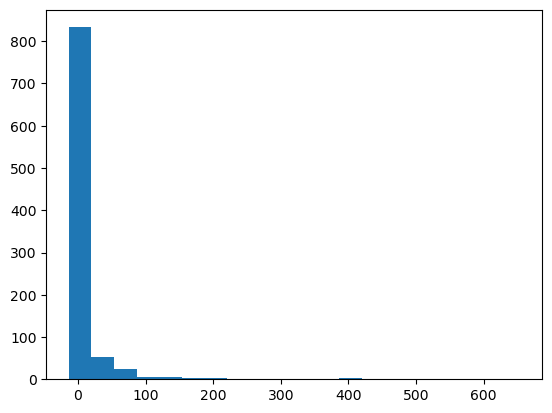

In [127]:
import matplotlib.pyplot as plt
plt.hist(y_val - np.exp(model.predict(X_val)), bins=20)
plt.show()

Очевидно, много больших выбросов, которые существенно ухудшают среднее.

In [132]:
np.quantile(y_val, 0.95)

56.799999999999955

Возьмем порог в час и будем считать, что дольше часа == долго.

In [141]:
((((y_val - pred)[y_val < 60])**2).mean())**(1 / 2)

9.503286233058393

In [142]:
((np.abs((y_val - pred)[y_val < 60])).mean())

4.205204870265527

Если уберем нецелую часть.

In [147]:
((((y_val - pred.astype(int))[y_val < 60])**2).mean())**(1 / 2)

9.622994820339903

In [148]:
((np.abs((y_val - pred.astype(int))[y_val < 60])).mean())

3.846674182638106

## Микро вывод

Скорее всего долгие поломки могут быть вызваны состоянием самолета, т.к. логично предположить, что при подозрении поломки, ее не разрешат за 10 и за 30 минут. Также долгие задержки могут быть связаны с экстремальными погодными условиями, однако по EDA проследить такие зависимости не получается. Скорее всего при большем кол-ве данных в реальной ситуации определять "долгие" задержки реально набором эвристик, а задержки до часа определять моделью.

Попробуем подобрать параметры модели.

In [152]:
model_cv = CatBoostRegressor()

grid = {
    'learning_rate': [0.05, 0.5],
    'depth': [6, 10, 16],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

randomized_search_result = model_cv.randomized_search(
    grid,
    X=train_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.6385766	test: 1.6296556	best: 1.6296556 (0)	total: 45.2ms	remaining: 45.1s
1:	learn: 1.5699598	test: 1.5626093	best: 1.5626093 (1)	total: 89ms	remaining: 44.4s
2:	learn: 1.5455725	test: 1.5399035	best: 1.5399035 (2)	total: 141ms	remaining: 47s
3:	learn: 1.5322197	test: 1.5269177	best: 1.5269177 (3)	total: 187ms	remaining: 46.6s
4:	learn: 1.5260204	test: 1.5220952	best: 1.5220952 (4)	total: 229ms	remaining: 45.6s
5:	learn: 1.5224566	test: 1.5191843	best: 1.5191843 (5)	total: 266ms	remaining: 44.1s
6:	learn: 1.5193962	test: 1.5158234	best: 1.5158234 (6)	total: 308ms	remaining: 43.7s
7:	learn: 1.5156704	test: 1.5126021	best: 1.5126021 (7)	total: 347ms	remaining: 43s
8:	learn: 1.5145850	test: 1.5120393	best: 1.5120393 (8)	total: 385ms	remaining: 42.4s
9:	learn: 1.5130187	test: 1.5108834	best: 1.5108834 (9)	total: 425ms	remaining: 42s
10:	learn: 1.5120916	test: 1.5100805	best: 1.5100805 (10)	total: 465ms	remaining: 41.8s
11:	learn: 1.5104077	test: 1.5086868	best: 1.5086868 (11)	

In [153]:
randomized_search_result['params']

{'depth': 10, 'l2_leaf_reg': 3, 'learning_rate': 0.05}

In [154]:
train_pool = Pool(
    X, y, 
    cat_features=cat_feats
)
test_pool = Pool(
    X_val, 
    cat_features=cat_feats
)

best_model = CatBoostRegressor(
    depth=10, 
    l2_leaf_reg=3, 
    learning_rate=0.05
)

best_model.fit(train_pool)

0:	learn: 1.5681448	total: 89.4ms	remaining: 1m 29s
1:	learn: 1.5640498	total: 183ms	remaining: 1m 31s
2:	learn: 1.5603485	total: 280ms	remaining: 1m 33s
3:	learn: 1.5569759	total: 377ms	remaining: 1m 33s
4:	learn: 1.5537726	total: 469ms	remaining: 1m 33s
5:	learn: 1.5509053	total: 552ms	remaining: 1m 31s
6:	learn: 1.5483534	total: 636ms	remaining: 1m 30s
7:	learn: 1.5457960	total: 726ms	remaining: 1m 29s
8:	learn: 1.5433237	total: 816ms	remaining: 1m 29s
9:	learn: 1.5410213	total: 899ms	remaining: 1m 29s
10:	learn: 1.5390592	total: 991ms	remaining: 1m 29s
11:	learn: 1.5368165	total: 1.08s	remaining: 1m 29s
12:	learn: 1.5349608	total: 1.17s	remaining: 1m 28s
13:	learn: 1.5333318	total: 1.26s	remaining: 1m 28s
14:	learn: 1.5317446	total: 1.34s	remaining: 1m 28s
15:	learn: 1.5301760	total: 1.44s	remaining: 1m 28s
16:	learn: 1.5287493	total: 1.52s	remaining: 1m 27s
17:	learn: 1.5273777	total: 1.61s	remaining: 1m 28s
18:	learn: 1.5255610	total: 1.71s	remaining: 1m 28s
19:	learn: 1.5243037	

In [155]:
best_pred = np.exp(best_model.predict(X_val)) - 1

In [158]:
(np.abs(best_pred - y_val)).mean()

11.330509809471708

In [159]:
np.sqrt(((best_pred - y_val)**2).mean())

43.76484734455877

In [160]:
((((y_val - best_pred)[y_val < 60])**2).mean())**(1 / 2)

9.604160284296473

In [163]:
((((y_val - best_pred.astype(int))[y_val < 60])**2).mean())**(1 / 2)

9.726647227635436

In [162]:
((np.abs((y_val - best_pred)[y_val < 60])).mean())

4.3416790489395165

In [161]:
((np.abs((y_val - best_pred.astype(int))[y_val < 60])).mean())

4.012401352874859

In [168]:
predictions = np.exp(best_model.predict(test)) - 1
test['delay'] = predictions
pd.DataFrame(test).to_csv('preds.csv', index=False, header=True)

In [169]:
np.exp(best_model.predict(test)) - 1

array([ 8.15944586,  8.15944586,  8.15944586, ..., 11.92425265,
        9.73934997, 12.75436128])